<a href="https://colab.research.google.com/github/peppe0101/Health_Insurance_Cross_Sell_Prediction/blob/main/Health_Insurance_Cross_Sell_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OUTLINE**

1.   [Importing libraries/modules](#scrollTo=PODIBt4xS2hb&line=1&uniqifier=1)
2.   [Exploratory Data Analysis](#scrollTo=Wtz_30GGRmyK&line=1&uniqifier=1)
  1.   [Univariate](#scrollTo=cFy42cLVEiY_&line=1&uniqifier=1)
  2. [Bivariate](#scrollTo=x-8C0xD_DGJ2)
  3. [Multivariate](#scrollTo=FTqjgGrYG8IO)
3. [Data Preparation](#scrollTo=5-KT_5gtb16L)
  1. [Encoding](#scrollTo=GEBrs2v-Npaf)
  2. [Tackling Imbalance](#scrollTo=NSshx6K9acH6)
  3. [Standardization](#scrollTo=Yc-WYCIp0-OS)
4.   [Model Evaluation](#scrollTo=wn2n9IZhczUy&line=1&uniqifier=1)
  1. [Creating Logistic Model](#scrollTo=YVTmdZUN4yJ2&line=1&uniqifier=1)
  2. [Model Evaluation](#scrollTo=_4gLFBqL7rrA&line=1&uniqifier=1)
  3. [Cross Validation](#scrollTo=7VAEmcfJORfn&line=1&uniqifier=1)
  4. [Conclusion](#scrollTo=WhGcmRoZaXvz&line=1&uniqifier=1)
5. [Previsions](#scrollTo=USZ4VCfwJcoN)
  1. [Training on whole Train Set](#scrollTo=hwW-EAGMQUOm)
  2. [Predictions on Test Set](#scrollTo=QDWiDLEmQavF)




# **1. Importing libraries/modules**
[Take me to Outline](#scrollTo=fLKKpiJRSEp-&line=5&uniqifier=1)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as ss

from scipy.stats import chi2_contingency 
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import precision_score, recall_score, accuracy_score,\
                                    balanced_accuracy_score,classification_report,roc_auc_score,\
                                    top_k_accuracy_score, roc_curve,auc,RocCurveDisplay,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

In [2]:
! pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction") #importing dataset from Kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: giuseppecurci
Your Kaggle Key: ··········


100%|██████████| 6.47M/6.47M [00:00<00:00, 52.8MB/s]

In [3]:
test = pd.read_csv("/content/health-insurance-cross-sell-prediction/test.csv")
train = pd.read_csv("/content/health-insurance-cross-sell-prediction/train.csv")

# **2. Exploratory Data Anlysis**
[Take me to Outline](#scrollTo=fLKKpiJRSEp-&line=5&uniqifier=1)

In [4]:
train_data_analysis = train.drop("id",axis=1)
train_data_analysis.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## **Questions**

1)Are males more intersted in car insurance?

2)Are older people more likely to show interest for a car insurance?(cut-off: >40 years)

3)Are people who had their vehicle previously damaged more intersted in car insurance?

4)The newer one's vehicle is, the more likely one is to buy a car insurance?(since the vehicle is probably more valuable)

## 2.1 Univariate

### **Check for NA**
There's no Na

In [5]:
train.isnull().sum() 

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

### **Description for numberical and categorical variables**

In [7]:
round(train_data_analysis.loc[:,["Age","Annual_Premium","Vintage"]].describe(),1)

,Age,Annual_Premium,Vintage
count,381109.0,381109.0,381109.0
mean,38.8,30564.4,154.3
std,15.5,17213.2,83.7
min,20.0,2630.0,10.0
25%,25.0,24405.0,82.0
50%,36.0,31669.0,154.0
75%,49.0,39400.0,227.0
max,85.0,540165.0,299.0


In [8]:
train_data_analysis.describe(include=["object"])

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


### **Check for imbalance in classes**


The classes in the `Response` variable appear to be imbalanced. 

In fact, for each "1"(positive) observation, there are more than 7 "0"(negative) ones -> ***7("0"):1("1")*** 

In [9]:
def imbalance_class(df,series):
  print(df[series].value_counts()/df.shape[0])
  freq_0 = df[series].value_counts()[0]
  freq_1 = df[series].value_counts()[1]
  print(f"The two classes have a ratio of: {freq_0/freq_1:.3}")

In [10]:
imbalance_class(train_data_analysis,"Response")

0    0.877437
1    0.122563
Name: Response, dtype: float64
The two classes have a ratio of: 7.16


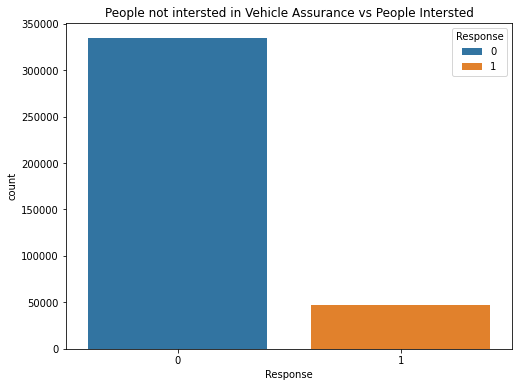

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(x="Response",hue="Response", data=train_data_analysis, dodge = False)         #dodge=False to properly align x-labels with bars
plt.title("People not intersted in Vehicle Assurance vs People Intersted")
plt.show()

`Gender`, `Previously_Insured` and `Vehicle_Damage` don't appear to be imbalanced

In [12]:
imbalance_class(train_data_analysis,"Gender")

Male      0.540761
Female    0.459239
Name: Gender, dtype: float64
The two classes have a ratio of: 1.18


In [13]:
imbalance_class(train_data_analysis,"Previously_Insured")

0    0.54179
1    0.45821
Name: Previously_Insured, dtype: float64
The two classes have a ratio of: 1.18


In [14]:
imbalance_class(train_data_analysis,"Vehicle_Damage")

Yes    0.504877
No     0.495123
Name: Vehicle_Damage, dtype: float64
The two classes have a ratio of: 1.02


`Driving_License` appear to be imbalanced with a ratio of 468("1"):1("0").

This should not be problematic anyway.

In [15]:
imbalance_class(train_data_analysis,"Driving_License")

1    0.997869
0    0.002131
Name: Driving_License, dtype: float64
The two classes have a ratio of: 0.00214


## **2.2 Bivariate Analysis**

### **Quantitative Variables**

`Age` 

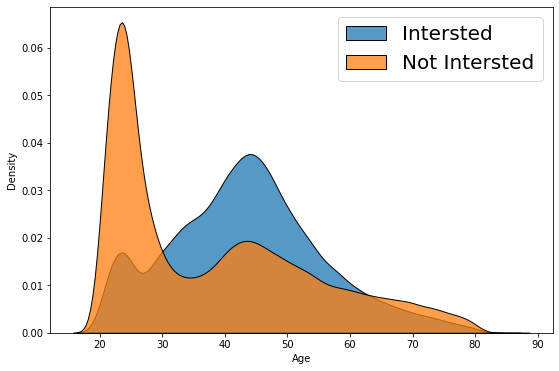

In [16]:
age_not_intersted = train_data_analysis.query("Response == 0")["Age"]
age_intersted = train_data_analysis.query("Response == 1")["Age"]

plt.figure(figsize=(9,6))
sns.kdeplot(data=age_intersted,label="Intersted",multiple='stack')
sns.kdeplot(data=age_not_intersted,label="Not Intersted",multiple='stack')
plt.legend(fontsize=20)
plt.show()

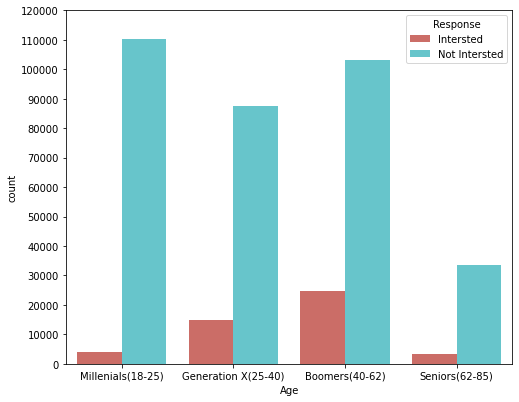

In [17]:
bins=[18, 25, 40, 62, 85]
labels=['Millenials(18-25)', 'Generation X(25-40)', 'Boomers(40-62)', 'Seniors(62-85)']
biva1 = pd.cut(train_data_analysis.Age, bins=bins, labels=labels)

train_data_analysis_resp_encod = train_data_analysis.copy()
Response = {0:"Not Intersted", 1:"Intersted"}
train_data_analysis_resp_encod.Response = train_data_analysis_resp_encod.Response.map(Response)

plt.figure(figsize=(8,6.5))
sns.countplot(x=biva1, data=train_data_analysis_resp_encod, hue='Response', palette='hls')
plt.ylim(0,120000)
plt.yticks(np.arange(0,130000,10000))
plt.show()

Now let's create a countplot with a cut-off of >=40 years old

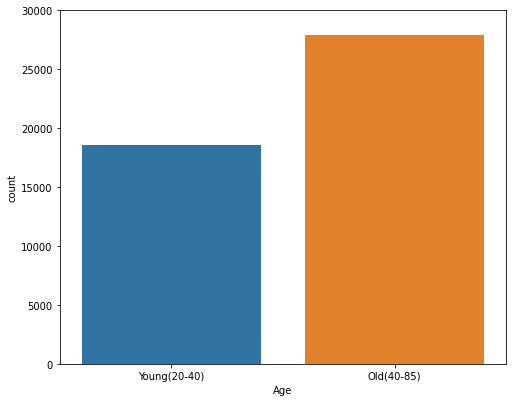

In [18]:
bins_young_old=[20, 40, 85]
labels_young_old=['Young(20-40)', 'Old(40-85)']
biva_age_old_young = pd.cut(train_data_analysis.query("Response==1")["Age"], bins=bins_young_old, labels=labels_young_old)
plt.figure(figsize=(8,6.5))
sns.countplot(x=biva_age_old_young, data=train_data_analysis)
plt.ylim(0,30000,5000)
plt.show()

Old people seem to be more intersted in buying a car insurance.
This makes perfect sense given that the older one is the more likely is to own a car and to have to money to afford an insurance.

Anyway, we'll now check the significance of this relationship with a chi-square test.

In [19]:
biva_chi_age_old = pd.cut(train_data_analysis["Age"], bins=bins_young_old, labels=labels_young_old)
train_data_analysis_1 = train_data_analysis.copy()
train_data_analysis_1.Age = biva_chi_age_old

In [20]:
contingency_age = pd.crosstab(train_data_analysis_1.Age, train_data_analysis_1.Response, margins=True)

In [21]:
value_age = np.array([contingency_age.iloc[0].values,
                  contingency_age.iloc[1].values])

In [22]:
chi2_age = chi2_contingency(value_age)
print(f"The p-value is {chi2_age[1]}, elder people are significantly more intersted in car insurance")

The p-value is 0.0, elder people are significantly more intersted in car insurance


### **Qualitative Variables**

`Gender`

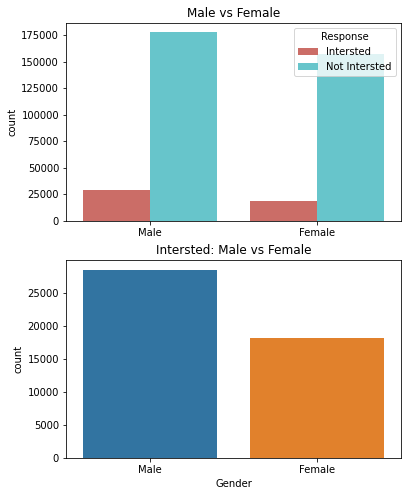

In [23]:
plt.figure(figsize=(6,8))

plt.subplot(2,1,1)
plt.title("Male vs Female")
sns.countplot(x="Gender", data=train_data_analysis_resp_encod, hue='Response', palette='hls')
plt.xlabel(xlabel=None)

plt.subplot(2,1,2)
plt.title("Intersted: Male vs Female")
sns.countplot(x="Gender", data=train_data_analysis.query("Response==1"))

plt.show()

Males seem to be more intersted in buying a car insurance.

Let's test the significance of the difference with chi squared test.

In [24]:
contingency_gender = pd.crosstab(train_data_analysis_1.Gender, train_data_analysis_1.Response, margins=True)

In [25]:
value_gender = np.array([contingency_gender.iloc[0].values,
                  contingency_gender.iloc[1].values])

In [26]:
chi2_age = chi2_contingency(value_gender)
print(f"The p-value is {chi2_age[1]:.1}, males are significantly more intersted in car insurance")

The p-value is 3e-228, males are significantly more intersted in car insurance


`Vehicle_Damage`

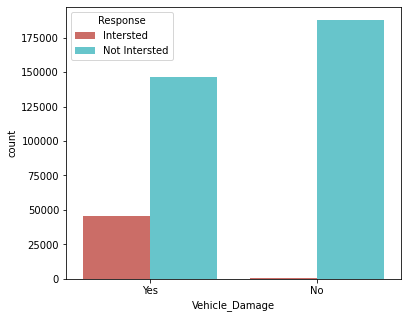

In [27]:
plt.figure(figsize=(6,5))
sns.countplot(x="Vehicle_Damage", data=train_data_analysis_resp_encod, hue='Response', palette='hls')
plt.show()

There's a massive difference between the two groups. People who had their vehicle previously damaged are clearly more intersted in buying a car insurance.

As the difference appears to be huge, we're not gonna check its significance this time.

`Vehicle_Age`

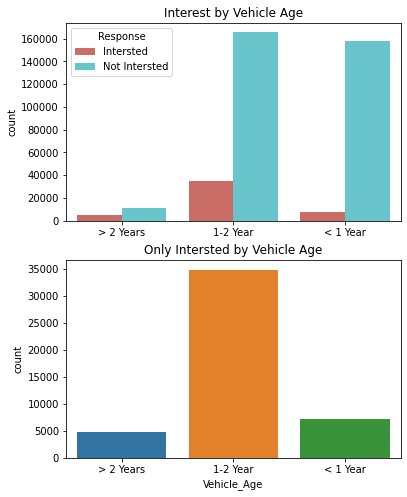

In [28]:
plt.figure(figsize=(6,8))

plt.subplot(2,1,1)
plt.title("Interest by Vehicle Age")
sns.countplot(x="Vehicle_Age", data=train_data_analysis_resp_encod, hue='Response', palette='hls')
plt.xlabel(xlabel=None)

plt.subplot(2,1,2)
plt.title("Only Intersted by Vehicle Age")
sns.countplot(x="Vehicle_Age",data=train_data_analysis.loc[train_data_analysis.Response==1])
plt.show()

The class that appears to be the most intersted it's `< 1 Year`, but `1-2 Year`.

Once again, the difference is so big that testing its significance would rather pointless.

## **2.3 Multivariate Analysis**

### **Correlation among quantitative variables**

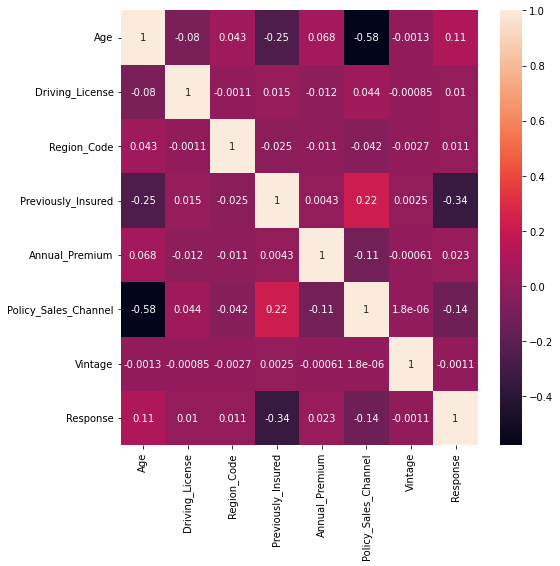

In [29]:
plt.figure(figsize=(8,8))
sns.heatmap(train_data_analysis.corr(),annot=True)
plt.show()

### **Correlation among qualitative variables**

In [30]:
qual_variables = train_data_analysis.select_dtypes(include="object")

**Creating a function to calculate Cramer's V to measure correlation between categorical variables**

I'm not the author of the function, in fact I took the code at the following link: https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix

In [31]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return round(np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1))),2)

**Creating confusion matrices**

In [32]:
Gender_V_age = pd.crosstab(qual_variables.Gender,qual_variables.Vehicle_Age)
Gender_V_dam = pd.crosstab(qual_variables.Gender,qual_variables.Vehicle_Damage)
Veh_age_damage = pd.crosstab(qual_variables.Vehicle_Age,qual_variables.Vehicle_Damage)

**Calculating cramer's V for each variable**

In [33]:
cramer_gen_Vage = cramers_corrected_stat(Gender_V_age)
cramer_gen_damage = cramers_corrected_stat(Gender_V_dam)
cramer_age_damage = cramers_corrected_stat(Veh_age_damage)

In [34]:
cramer_df = pd.DataFrame({
    "gender": [1, cramer_gen_Vage,cramer_gen_damage],
    "Vehicle_Age": [cramer_gen_Vage,1,cramer_age_damage],
    "Vehicle_Damage": [cramer_gen_damage,cramer_age_damage,1]
}, index=["gender","Vehicle_Age","Vehicle_Damage"])

**Finally, we create a heatmap to show the correlations among the variables**

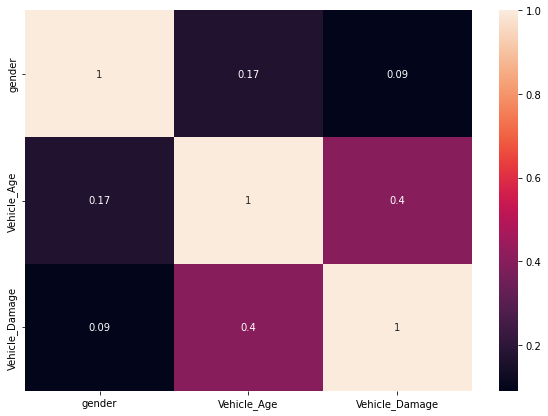

In [35]:
plt.figure(figsize=(10,7))
sns.heatmap(cramer_df,annot=True)
plt.show()

# **3. Data Preparation**
[Take me to Outline](#scrollTo=fLKKpiJRSEp-&line=5&uniqifier=1)

In [36]:
train_1 = train.copy()

In [37]:
train_1

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


## **3.1 Encoding**

In order to use `Region_Code` we have two options. 

The first one involves finding another dataset that associate the Region_Code with its region and then we should create clusters by population(or other relevant information).

While the second one consists in just replacing the code with the average response by Region_Code. As the latter is more viable, we'll choose this one. 

In [38]:
target_encode_region_code=train_1.groupby('Region_Code')['Response'].mean()
train_1.loc[:, 'Region_Code'] = train_1['Region_Code'].map(target_encode_region_code)

**One-hot encoding for `Gender`, `Vehicle_Age`**

In [39]:
train_1 = pd.get_dummies(train_1, columns=["Gender","Vehicle_Age"])

**Ordinal-Encoding `Vehicle_Damage`**

In [40]:
Vehicle_Damage_labels = {"Yes":1,"No":0}
train_1.Vehicle_Damage = train_1.Vehicle_Damage.map(Vehicle_Damage_labels)
train_1.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,1,44,1,0.187163,0,1,40454.0,26.0,217,1,0,1,0,0,1
1,2,76,1,0.127662,0,0,33536.0,26.0,183,0,0,1,1,0,0
2,3,47,1,0.187163,0,1,38294.0,26.0,27,1,0,1,0,0,1
3,4,21,1,0.112760,1,0,28619.0,152.0,203,0,0,1,0,1,0
4,5,29,1,0.121776,1,0,27496.0,152.0,39,0,1,0,0,1,0


## **3.2 Tackling Imbalance**


Given the small size of the dataset, "undersampling" doesn't seem to be an ideal option(neither does combining undersampling with oversampling)

### Oversampling

In [41]:
oversample = RandomOverSampler(sampling_strategy="minority",random_state=42)

In [42]:
X = train_1.drop("Response",axis=1).values
y = train_1["Response"].values
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X, y, test_size=.3, random_state=42)

In [43]:
X_over_train, y_over_train = oversample.fit_resample(X_over_train, y_over_train)

In [44]:
unique, counts = np.unique(y_over_train, return_counts=True)
dict(zip(unique, counts))

{0: 234204, 1: 234204}

### Penalizing most-frequent class

This is done by setting the argument `class_weight="balanced"` when instantiating the Logistic Regression model.

In fact, by doing so we will adjust the weights inversely proportional to the class frequencies.

## **3.3 Standardization**

### Train data

In [45]:
X = train_1.drop("Response",axis=1).values
y = train_1["Response"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
ss_train_data = StandardScaler()
X_train = ss_train_data.fit_transform(X_train)
X_test = ss_train_data.transform(X_test)

### Oversampled data

In [47]:
ss_over_data = StandardScaler()
X_over_train = ss_over_data.fit_transform(X_over_train)
X_over_test = ss_over_data.transform(X_test)

# **4. Models' Evaluation** 
[Take me to Outline](#scrollTo=fLKKpiJRSEp-&line=5&uniqifier=1)

In [48]:
train_1.Response.unique()

array([1, 0])

## **4.1 Creating Logistic model**

### **Base-line model(no balancing)**

In [49]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

### **Oversample Data**

In [50]:
lr_oversampled = LogisticRegression()
lr_oversampled.fit(X_over_train,y_over_train)

LogisticRegression()

### **Weight_class="Balanced"**

In [51]:
lr_weighted = LogisticRegression(class_weight="balanced")
lr_weighted.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

### No multicollinearity

In [52]:
#find design matrix for linear regression model using 'rating' as response variable 
y_vif, X_vif = dmatrices('Response ~ Gender+Age+Driving_License+Region_Code+Previously_Insured+Vehicle_Age+Vehicle_Damage+Annual_Premium+Policy_Sales_Channel+Vintage', data=train, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['variable'] = X_vif.columns
vif

,VIF,variable
0,551.328083,Intercept
1,1.030603,Gender[T.Male]
2,3.035599,Vehicle_Age[T.< 1 Year]
3,1.082763,Vehicle_Age[T.> 2 Years]
4,3.201780,Vehicle_Damage[T.Yes]
5,2.893777,Age
6,1.008111,Driving_License
7,1.002924,Region_Code
8,3.156807,Previously_Insured
9,1.021661,Annual_Premium


## **4.2 Model Evaluation**

P.S. I won't change the parameters of the decision boundary cause in order to do so I would need further information about the business of the company(knowledge-domain)

e.g. Is a false-positive worse than a false-negative? That, without a doubt, depends on the domain  

### **Baseline model(no balancing)**

**Classification Report**

In [53]:
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
y_pred_test = lr.predict(X_test)
y_proba_test =  lr.predict_proba(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    234204
           1       0.03      0.00      0.00     32572

    accuracy                           0.88    266776
   macro avg       0.45      0.50      0.47    266776
weighted avg       0.77      0.88      0.82    266776

TEST REPORT
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100195
           1       0.07      0.00      0.00     14138

    accuracy                           0.88    114333
   macro avg       0.47      0.50      0.47    114333
weighted avg       0.78      0.88      0.82    114333



As the model's performance are already very poor, I won't go ahead with visualizing cofusion matrix, ROC curve etc.

We can discard this one.

### **Weight_class="Balanced"**

**Classification Report**

In [54]:
y_pred_train_weighted = lr_weighted.predict(X_train)
y_proba_train_weighted = lr_weighted.predict_proba(X_train)
y_pred_test_weighted = lr_weighted.predict(X_test)
y_proba_test_weighted =  lr_weighted.predict_proba(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train_weighted))
print("TEST REPORT")
print(classification_report(y_test, y_pred_test_weighted))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.99      0.60      0.75    234204
           1       0.25      0.97      0.40     32572

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.60      0.75    100195
           1       0.25      0.97      0.40     14138

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.58    114333
weighted avg       0.90      0.64      0.70    114333



In [55]:
X_train.shape

(266776, 14)

**Confusion Matrix**

In [56]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall=True):

  cm = confusion_matrix(y_true, y_pred) # tn, fp, fn, tp 

  df_cm = pd.DataFrame(cm, index = labels,
                    columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
  sns.heatmap(df_cm, annot=True, fmt='g')

  if show_precision_recall:
    plt.text(0, -0.1, f"Precision: {(cm[1][1]/(cm[1][1]+cm[0][1])):.3f}")
    plt.text(1, -0.1, f"Recall: {(cm[1][1]/(cm[1][1]+cm[1][0])):.3f}")

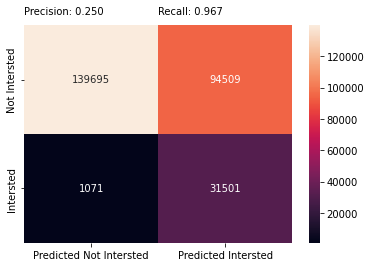

In [57]:
plot_confusion_matrix(y_train, y_pred_train_weighted, ["Not Intersted", "Intersted"])

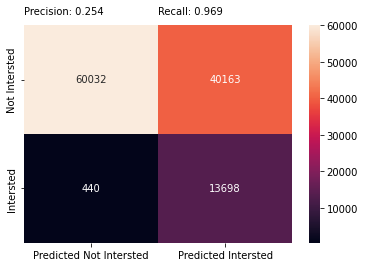

In [58]:
plot_confusion_matrix(y_test, y_pred_test_weighted, ["Not Intersted", "Intersted"])

**ROC Curve**

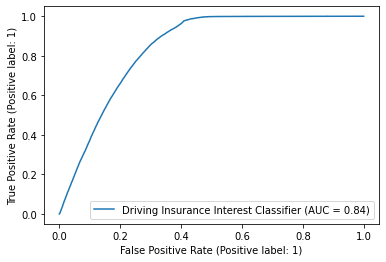

In [59]:
RocCurveDisplay.from_estimator(lr_weighted, X_train, y_train, name="Driving Insurance Interest Classifier")

### **Oversample Data**

**Classification Report**

In [60]:
y_pred_train_oversampled = lr_oversampled.predict(X_train)          # Note: when evaluating the model, we don't have to use the oversampled data cause it
y_proba_train_oversampled = lr_oversampled.predict_proba(X_train)      # was only meant for the training of the model
y_pred_test_oversampled = lr_oversampled.predict(X_test)
y_proba_test_oversampled =  lr_oversampled.predict_proba(X_test)

print("TRAIN REPORT")
print(classification_report(y_train, y_pred_train_oversampled))          
print("TEST REPORT")
print(classification_report(y_test, y_pred_test_oversampled))

TRAIN REPORT
              precision    recall  f1-score   support

           0       1.00      0.57      0.72    234204
           1       0.24      0.99      0.39     32572

    accuracy                           0.62    266776
   macro avg       0.62      0.78      0.55    266776
weighted avg       0.90      0.62      0.68    266776

TEST REPORT
              precision    recall  f1-score   support

           0       1.00      0.57      0.72    100195
           1       0.24      0.99      0.39     14138

    accuracy                           0.62    114333
   macro avg       0.62      0.78      0.56    114333
weighted avg       0.90      0.62      0.68    114333



**Confusion Matrix**

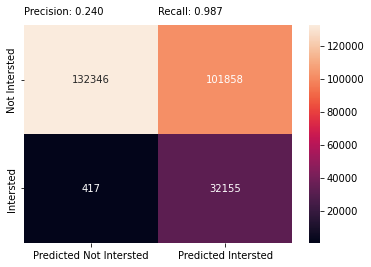

In [61]:
plot_confusion_matrix(y_train, y_pred_train_oversampled, ["Not Intersted", "Intersted"])

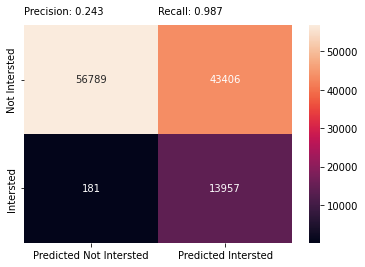

In [62]:
plot_confusion_matrix(y_test, y_pred_test_oversampled, ["Not Intersted", "Intersted"])

**ROC Curve**

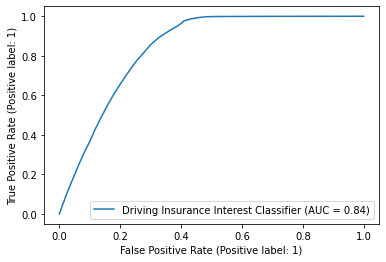

In [63]:
RocCurveDisplay.from_estimator(lr_oversampled, X_train, y_train, name="Driving Insurance Interest Classifier")

## **4.3 Cross Validation**

### **Weight_class="Balanced"**

In [64]:
score = cross_val_score(lr_weighted,X_train,y_train,cv=10, scoring="f1_micro")

In [65]:
round(np.mean(score),2)

0.64

### **Oversample Data**

In [66]:
steps = [('over', RandomOverSampler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_micro', cv=cv)
round(np.mean(scores),2)

0.64

## **4.4 Conclusion**

In [67]:
print("TEST REPORT WEIGHTED MODEL")
print(classification_report(y_test, y_pred_test_weighted))
print("TEST REPORT OVERSAMPLED MODEL")
print(classification_report(y_over_test, y_pred_test_oversampled))

TEST REPORT WEIGHTED MODEL
              precision    recall  f1-score   support

           0       0.99      0.60      0.75    100195
           1       0.25      0.97      0.40     14138

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.58    114333
weighted avg       0.90      0.64      0.70    114333

TEST REPORT OVERSAMPLED MODEL
              precision    recall  f1-score   support

           0       1.00      0.57      0.72    100195
           1       0.24      0.99      0.39     14138

    accuracy                           0.62    114333
   macro avg       0.62      0.78      0.56    114333
weighted avg       0.90      0.62      0.68    114333



Comparing the scores in the cross-validation and the performance in the classification report, it doesn't appear to be any relevant difference between the two ways of tackling the problem of imbalanced classes.

#**5. Previsions**
Now we'll make our predictions on the Test Set.

The final results we'll be saved in an Excel document. 

[Take me to Outline](#scrollTo=fLKKpiJRSEp-&line=5&uniqifier=1)

## **5.1 Training on whole Train Set**


**Encoding of the test data**

In [68]:
test_1 = test.drop("id",axis=1)

test_1.loc[:, 'Region_Code'] = test_1['Region_Code'].map(target_encode_region_code) 
test_1 = pd.get_dummies(test_1, columns=["Gender","Vehicle_Age"])
Vehicle_Damage_labels = {"Yes":1,"No":0}
test_1.Vehicle_Damage = test_1.Vehicle_Damage.map(Vehicle_Damage_labels)

**Creating arrays to train and test the model**

In [69]:
X_train_final = train_1.drop(["Response","id"],axis=1).values
Y_train_final = train_1.Response.values
X_test_final = test_1.values

**Creating the model**

I'll tackle the problem of imbalanced classes just by using `class_weight="balanced"` as there's no significant difference from using `RandomOverSampler()`.

In [70]:
ss_final = StandardScaler()
X_train_final = ss_final.fit_transform(X_train_final)
X_test_final = ss_final.transform(X_test_final)

In [71]:
final_model = LogisticRegression(class_weight="balanced")
final_model.fit(X_train_final,Y_train_final)

LogisticRegression(class_weight='balanced')

In [72]:
y_pred_train_final = final_model.predict(X_train_final)
y_proba_train_final = final_model.predict_proba(X_train_final)

print("TRAIN REPORT")
print(classification_report(Y_train_final, y_pred_train_final))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.99      0.60      0.75    334399
           1       0.25      0.97      0.40     46710

    accuracy                           0.64    381109
   macro avg       0.62      0.78      0.57    381109
weighted avg       0.90      0.64      0.70    381109



## **5.2 Predictions on Test Set**

In [73]:
y_pred_test_final = final_model.predict(X_test_final)
y_proba_test_final = final_model.predict_proba(X_test_final)

In [74]:
df_result = pd.DataFrame({
    "ID number":test["id"],
    "prediction":y_pred_test_final,
    "probability":y_proba_test_final.max(axis=1).round(4)
})

df_result.to_excel("Car_insurance_prediction.xlsx",index=False)